# Risk-aware MCTS
#### Four-state MDP

In [1]:
import os
import json
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")

matplotlib.rcParams['text.usetex'] =  True
plt.rc('text.latex', preamble=r'\usepackage{pifont} \usepackage{amsfonts}')
matplotlib.rcParams.update({'font.size': 20})

sns.set_palette("colorblind")

In [2]:
def calculate_erm(dist, beta):
    return (1.0 / beta) * np.log( (1/len(dist)) * np.sum(np.exp(beta*dist)) )

In [3]:
def erm_ci(samples: np.ndarray, beta : float, num_resamples: int=25_000):
    # Confidence interval estimation.
    resampled = np.random.choice(samples,
                                size=(len(samples), num_resamples),
                                replace=True).T
    # print("resampled.shape", resampled.shape)
    erms = (1.0 / beta) * np.log((1/resampled.shape[1]) * np.sum(np.exp(beta*resampled), axis=1))
    confidence_interval = [np.percentile(erms, 5), np.percentile(erms, 95)]

    return confidence_interval

### Load experiments data

In [4]:
# np.sqrt(np.log(Ns) / Na) bonus experiments.
""" erm_mcts_planner_paths = {
    0.1: {
        100: 'four_state_mdp_mcts_gamma_0.9_beta_0.1_2025-12-29-19-43-470',
        200: 'four_state_mdp_mcts_gamma_0.9_beta_0.1_2025-12-29-19-53-070',
        500: 'four_state_mdp_mcts_gamma_0.9_beta_0.1_2025-12-29-20-57-040',
        1_000: 'four_state_mdp_mcts_gamma_0.9_beta_0.1_2025-12-30-12-17-520', # 'four_state_mdp_mcts_gamma_0.9_beta_0.1_2025-12-29-11-43-450',
    },
    0.5: {
        100: 'four_state_mdp_mcts_gamma_0.9_beta_0.5_2025-12-29-20-10-190',
        200: 'four_state_mdp_mcts_gamma_0.9_beta_0.5_2025-12-29-20-38-040',
        500: 'four_state_mdp_mcts_gamma_0.9_beta_0.5_2025-12-29-21-42-370',
        1_000: 'four_state_mdp_mcts_gamma_0.9_beta_0.5_2025-12-29-13-18-380',
    },
    1.0: {
        100: 'four_state_mdp_mcts_gamma_0.9_beta_1.0_2025-12-30-00-19-350',
        200: 'four_state_mdp_mcts_gamma_0.9_beta_1.0_2025-12-30-00-25-340',
        500: 'four_state_mdp_mcts_gamma_0.9_beta_1.0_2025-12-30-00-37-450',
        1_000: 'four_state_mdp_mcts_gamma_0.9_beta_1.0_2025-12-30-01-09-370',
    },
}
erm_mcts_planner_data = {}
for erm_beta in erm_mcts_planner_paths.keys():
    erm_mcts_planner_data[erm_beta] = {}
    for exp_step, mcts_path in erm_mcts_planner_paths[erm_beta].items():
        with open("data/" + mcts_path + "/exp_data.json", 'r') as f:
            data = json.load(f)
            data = json.loads(data)
        f.close()
        erm_mcts_planner_data[erm_beta][exp_step] = data
# print(erm_mcts_planner_data)

#######################################################################################
#######################################################################################
#######################################################################################
accrued_costs_mcts_planner_paths = {
    0.1: {
        100: 'four_state_mdp_mcts_gamma_0.9_beta_0.1_2025-12-29-22-19-34',
        200: 'four_state_mdp_mcts_gamma_0.9_beta_0.1_2025-12-29-22-28-23',
        500: 'four_state_mdp_acc-mcts_gamma_0.9_beta_0.1_2025-12-30-10-19-09',
        1_000: 'four_state_mdp_mcts_gamma_0.9_beta_0.1_2025-12-27-13-54-13',
    },
    0.5: {
        100: 'four_state_mdp_acc-mcts_gamma_0.9_beta_0.5_2025-12-29-22-48-02',
        200: 'four_state_mdp_acc-mcts_gamma_0.9_beta_0.5_2025-12-29-22-53-46',
        500: 'four_state_mdp_acc-mcts_gamma_0.9_beta_0.5_2025-12-29-23-05-11',
        1_000: 'four_state_mdp_mcts_gamma_0.9_beta_0.5_2025-12-27-14-01-23',
    },
    1.0: {
        100: 'four_state_mdp_acc-mcts_gamma_0.9_beta_1.0_2025-12-29-23-33-51',
        200: 'four_state_mdp_acc-mcts_gamma_0.9_beta_1.0_2025-12-29-23-39-33',
        500: 'four_state_mdp_acc-mcts_gamma_0.9_beta_1.0_2025-12-29-23-50-57', #'four_state_mdp_acc-mcts_gamma_0.9_beta_1.0_2025-12-30-22-15-350'
        1_000: 'four_state_mdp_mcts_gamma_0.9_beta_1.0_2025-12-27-14-08-48',
    },
}
accrued_costs_mcts_planner_data = {}
for erm_beta in erm_mcts_planner_paths.keys():
    accrued_costs_mcts_planner_data[erm_beta] = {}
    for exp_step, mcts_path in accrued_costs_mcts_planner_paths[erm_beta].items():
        # Load MCTS planner data and MDP.
        with open("data/" + mcts_path + "/exp_data.json", 'r') as f:
            data = json.load(f)
            data = json.loads(data)
        f.close()
        accrued_costs_mcts_planner_data[erm_beta][exp_step] = data
# print(accrued_costs_mcts_planner_data)

#######################################################################################
#######################################################################################
#######################################################################################
erm_bi_paths = {
    0.1: 'four_state_mdp_erm-backward-induction_gamma_0.9_beta_0.1_2025-11-17-13-55-43',
    0.5: "four_state_mdp_erm-backward-induction_gamma_0.9_beta_0.5_2025-11-17-13-56-58",
    1.0: "four_state_mdp_erm-backward-induction_gamma_0.9_beta_1.0_2025-11-17-13-57-11",
}
erm_bi_data = {}
for erm_beta, erm_bi_path in erm_bi_paths.items():
    # Load MCTS planner data and MDP.
    with open("data/" + erm_bi_path + "/exp_data.json", 'r') as f:
        data = json.load(f)
        data = json.loads(data)
    f.close()
    erm_bi_data[erm_beta] = data
# print(erm_bi_data) """

' erm_mcts_planner_paths = {\n    0.1: {\n        100: \'four_state_mdp_mcts_gamma_0.9_beta_0.1_2025-12-29-19-43-470\',\n        200: \'four_state_mdp_mcts_gamma_0.9_beta_0.1_2025-12-29-19-53-070\',\n        500: \'four_state_mdp_mcts_gamma_0.9_beta_0.1_2025-12-29-20-57-040\',\n        1_000: \'four_state_mdp_mcts_gamma_0.9_beta_0.1_2025-12-30-12-17-520\', # \'four_state_mdp_mcts_gamma_0.9_beta_0.1_2025-12-29-11-43-450\',\n    },\n    0.5: {\n        100: \'four_state_mdp_mcts_gamma_0.9_beta_0.5_2025-12-29-20-10-190\',\n        200: \'four_state_mdp_mcts_gamma_0.9_beta_0.5_2025-12-29-20-38-040\',\n        500: \'four_state_mdp_mcts_gamma_0.9_beta_0.5_2025-12-29-21-42-370\',\n        1_000: \'four_state_mdp_mcts_gamma_0.9_beta_0.5_2025-12-29-13-18-380\',\n    },\n    1.0: {\n        100: \'four_state_mdp_mcts_gamma_0.9_beta_1.0_2025-12-30-00-19-350\',\n        200: \'four_state_mdp_mcts_gamma_0.9_beta_1.0_2025-12-30-00-25-340\',\n        500: \'four_state_mdp_mcts_gamma_0.9_beta_1.0_202

In [5]:
# np.sqrt(np.sqrt(Ns) / Na) bonus experiments.
mdp_name="two_paths"
erm_mcts_planner_paths = {
    0.01: {
        100: 'two_paths_mdp_erm-mcts_gamma_0.99_beta_0.01_2026-01-30-11-59-080',
        200: 'two_paths_mdp_erm-mcts_gamma_0.99_beta_0.01_2026-01-30-12-03-030',
        500: 'two_paths_mdp_erm-mcts_gamma_0.99_beta_0.01_2026-01-30-12-06-410',
        1_000: 'two_paths_mdp_erm-mcts_gamma_0.99_beta_0.01_2026-01-30-12-46-170',
        2000: 'two_paths_mdp_erm-mcts_gamma_0.99_beta_0.01_2026-02-02-17-59-070',
        3500: 'two_paths_mdp_erm-mcts_gamma_0.99_beta_0.01_2026-02-02-18-41-130',
        5000: 'two_paths_mdp_erm-mcts_gamma_0.99_beta_0.01_2026-02-02-14-40-410',
        10_000: 'two_paths_mdp_erm-mcts_gamma_0.99_beta_0.01_2026-02-03-11-07-070',
    },
    0.1: {
        100: 'two_paths_mdp_erm-mcts_gamma_0.99_beta_0.1_2026-01-30-11-59-340',
        200: 'two_paths_mdp_erm-mcts_gamma_0.99_beta_0.1_2026-01-30-12-03-440',
        500: 'two_paths_mdp_erm-mcts_gamma_0.99_beta_0.1_2026-01-30-12-09-150',
        1_000: 'two_paths_mdp_erm-mcts_gamma_0.99_beta_0.1_2026-02-03-16-22-440',
        10_000: 'two_paths_mdp_erm-mcts_gamma_0.99_beta_0.1_2026-02-04-18-30-490',
    },
}
erm_mcts_planner_data = {}
for erm_beta in erm_mcts_planner_paths.keys():
    erm_mcts_planner_data[erm_beta] = {}
    for exp_step, mcts_path in erm_mcts_planner_paths[erm_beta].items():
        with open("data/" + mcts_path + "/exp_data.json", 'r') as f:
            data = json.load(f)
            data = json.loads(data)
        f.close()
        erm_mcts_planner_data[erm_beta][exp_step] = data
# print(erm_mcts_planner_data)

#######################################################################################
#######################################################################################
#######################################################################################
accrued_costs_mcts_planner_paths = {
    0.01: {
        100: 'two_paths_mdp_acc-mcts_gamma_0.99_beta_0.01_2026-01-30-12-00-080',
        200: 'two_paths_mdp_acc-mcts_gamma_0.99_beta_0.01_2026-01-30-12-01-430',
        500: 'two_paths_mdp_acc-mcts_gamma_0.99_beta_0.01_2026-01-30-12-04-320',
        1_000: 'two_paths_mdp_acc-mcts_gamma_0.99_beta_0.01_2026-01-30-13-09-020',
        2_000: 'two_paths_mdp_acc-mcts_gamma_0.99_beta_0.01_2026-01-30-13-03-460',
        3500: 'two_paths_mdp_acc-mcts_gamma_0.99_beta_0.01_2026-02-03-11-46-370',
        5_000: 'two_paths_mdp_acc-mcts_gamma_0.99_beta_0.01_2026-01-30-13-09-020',
        10_000: 'two_paths_mdp_acc-mcts_gamma_0.99_beta_0.01_2026-02-03-13-14-160',
    },
    0.1: {
        100: 'two_paths_mdp_acc-mcts_gamma_0.99_beta_0.1_2026-01-30-12-01-160',
        200: 'two_paths_mdp_acc-mcts_gamma_0.99_beta_0.1_2026-01-30-12-02-300',
        500: 'two_paths_mdp_acc-mcts_gamma_0.99_beta_0.1_2026-01-30-12-05-350',
        1_000: 'two_paths_mdp_acc-mcts_gamma_0.99_beta_0.1_2026-01-30-12-13-520',
        10_000: 'two_paths_mdp_acc-mcts_gamma_0.99_beta_0.1_2026-02-04-21-50-160',
    },
}
accrued_costs_mcts_planner_data = {}
for erm_beta in erm_mcts_planner_paths.keys():
    accrued_costs_mcts_planner_data[erm_beta] = {}
    for exp_step, mcts_path in accrued_costs_mcts_planner_paths[erm_beta].items():
        # Load MCTS planner data and MDP.
        with open("data/" + mcts_path + "/exp_data.json", 'r') as f:
            data = json.load(f)
            data = json.loads(data)
        f.close()
        accrued_costs_mcts_planner_data[erm_beta][exp_step] = data
# print(accrued_costs_mcts_planner_data)

#######################################################################################
#######################################################################################
#######################################################################################
erm_bi_paths = {
    0.01: 'two_paths_mdp_erm-backward-induction_gamma_0.99_beta_0.01_2026-01-30-11-58-46',
    0.1: "two_paths_mdp_erm-backward-induction_gamma_0.99_beta_0.1_2026-01-30-11-58-55",
}
erm_bi_data = {}
for erm_beta, erm_bi_path in erm_bi_paths.items():
    # Load MCTS planner data and MDP.
    with open("data/" + erm_bi_path + "/exp_data.json", 'r') as f:
        data = json.load(f)
        data = json.loads(data)
    f.close()
    erm_bi_data[erm_beta] = data
# print(erm_bi_data)

**RUNNING** 79593: Acc-MCTS with 4k exp. steps

### Compare ERM's of the distribution of costs obtained by different algorithms

ERM-BI: 9.71 ; CI's: [7.725530557208006, 12.788814972543301] ; CI's (lenghts): 1.99 3.08
Acc-MCTS: 10.09 ; CI's: [8.770183254197407, 12.179628475744561] ; CI's (lenghts): 1.32 2.09
ERM-MCTS: 9.15 ; CI's: [9.041169808039504, 9.269299477961274] ; CI's (lenghts): 0.11 0.11


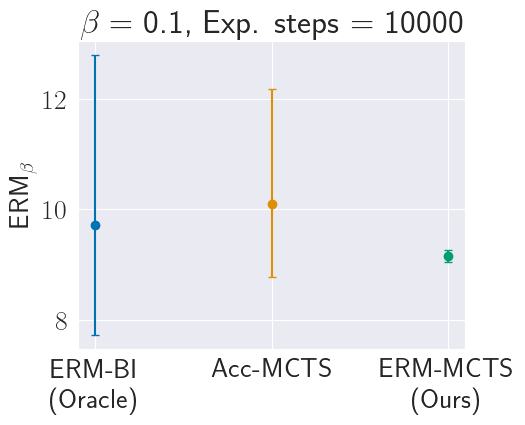

In [6]:
erm_beta_to_plot = 0.1
exp_steps_to_plot = 10_000

plt.figure(figsize=(5.0, 4.0))

# ERM-BI.
erm_val = calculate_erm(np.array(erm_bi_data[erm_beta_to_plot]["f_vals"]), beta=erm_beta_to_plot)
ci_up_length = erm_val - erm_ci(np.array(erm_bi_data[erm_beta_to_plot]["f_vals"]), beta=erm_beta_to_plot)[0]
ci_down_length = erm_ci(np.array(erm_bi_data[erm_beta_to_plot]["f_vals"]), beta=erm_beta_to_plot)[1] - erm_val
print("ERM-BI:", round(erm_val, 2), "; CI's:", erm_ci(np.array(erm_bi_data[erm_beta_to_plot]["f_vals"]), beta=erm_beta_to_plot), "; CI's (lenghts):", round(ci_up_length, 2), round(ci_down_length, 2))

# Accrued costs-MCTS.
erm_val = calculate_erm(np.array(accrued_costs_mcts_planner_data[erm_beta_to_plot][exp_steps_to_plot]["f_vals"]), beta=erm_beta_to_plot)
ci_up_length = erm_val - erm_ci(np.array(accrued_costs_mcts_planner_data[erm_beta_to_plot][exp_steps_to_plot]["f_vals"]), beta=erm_beta_to_plot)[0]
ci_down_length = erm_ci(np.array(accrued_costs_mcts_planner_data[erm_beta_to_plot][exp_steps_to_plot]["f_vals"]), beta=erm_beta_to_plot)[1] - erm_val
print("Acc-MCTS:", round(erm_val, 2), "; CI's:", erm_ci(np.array(accrued_costs_mcts_planner_data[erm_beta_to_plot][exp_steps_to_plot]["f_vals"]), beta=erm_beta_to_plot), "; CI's (lenghts):", round(ci_up_length, 2), round(ci_down_length, 2))

# ERM-MCTS.
erm_val = calculate_erm(np.array(erm_mcts_planner_data[erm_beta_to_plot][exp_steps_to_plot]["f_vals"]), beta=erm_beta_to_plot)
ci_up_length = erm_val - erm_ci(np.array(erm_mcts_planner_data[erm_beta_to_plot][exp_steps_to_plot]["f_vals"]), beta=erm_beta_to_plot)[0]
ci_down_length = erm_ci(np.array(erm_mcts_planner_data[erm_beta_to_plot][exp_steps_to_plot]["f_vals"]), beta=erm_beta_to_plot)[1] - erm_val
print("ERM-MCTS:", round(erm_val, 2), "; CI's:", erm_ci(np.array(erm_mcts_planner_data[erm_beta_to_plot][exp_steps_to_plot]["f_vals"]), beta=erm_beta_to_plot), "; CI's (lenghts):", round(ci_up_length, 2), round(ci_down_length, 2))

# ERM-BI.
erm_val = calculate_erm(np.array(erm_bi_data[erm_beta_to_plot]["f_vals"]), beta=erm_beta_to_plot)
cis = erm_ci(np.array(erm_bi_data[erm_beta_to_plot]["f_vals"]), beta=erm_beta_to_plot)
errors = np.array([erm_val - cis[0], cis[1] - erm_val]).reshape(-1,1)
plt.errorbar(1, erm_val, yerr=errors, capsize=3, fmt='o', label="ERM-BI")

# Acc-MCTS.
erm_val = calculate_erm(np.array(accrued_costs_mcts_planner_data[erm_beta_to_plot][exp_steps_to_plot]["f_vals"]), beta=erm_beta_to_plot)
cis = erm_ci(np.array(accrued_costs_mcts_planner_data[erm_beta_to_plot][exp_steps_to_plot]["f_vals"]), beta=erm_beta_to_plot)
errors = np.array([erm_val - cis[0], cis[1] - erm_val]).reshape(-1,1)
plt.errorbar(2, erm_val, yerr=errors, capsize=3, fmt='o', label="Acc-MCTS")

# ERM-MCTS.
erm_val = calculate_erm(np.array(erm_mcts_planner_data[erm_beta_to_plot][exp_steps_to_plot]["f_vals"]), beta=erm_beta_to_plot)
cis = erm_ci(np.array(erm_mcts_planner_data[erm_beta_to_plot][exp_steps_to_plot]["f_vals"]), beta=erm_beta_to_plot)
errors = np.array([erm_val - cis[0], cis[1] - erm_val]).reshape(-1,1)
plt.errorbar(3, erm_val, yerr=errors, capsize=3, fmt='o', label="ERM-MCTS")

# ax.set_ylim([-1.5,-0.2])
plt.xticks([1,2,3], ["ERM-BI\n(Oracle)", "Acc-MCTS", "ERM-MCTS\n(Ours)"])
plt.grid()
# plt.legend(loc=4)

plt.title(r'$\beta=$ ' + str(erm_beta_to_plot) + ", Exp. steps = " + str(exp_steps_to_plot))
plt.ylabel(r"ERM$_\beta$")

os.makedirs("figs/", exist_ok=True)
plt.savefig(f'figs/{mdp_name}_plot2_beta_{erm_beta_to_plot}.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

### Compare ERM's of the distribution of costs obtained by different algorithms (expansion steps)

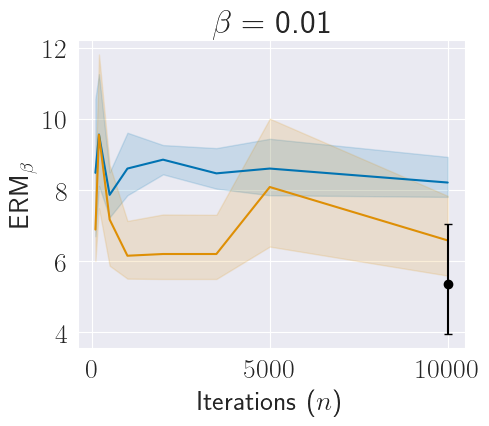

In [7]:
erm_beta_to_plot = 0.01
exp_steps_to_plot = [100, 200,500,1000,2000,3500,5000,10_000]

plt.figure(figsize=(5.0, 4.0))

# Acc-MCTS
ys = []
cis = []
for exp_step in exp_steps_to_plot:
    ys.append(calculate_erm(np.array(accrued_costs_mcts_planner_data[erm_beta_to_plot][exp_step]["f_vals"]), beta=erm_beta_to_plot))
    cis.append(np.array(erm_ci(np.array(accrued_costs_mcts_planner_data[erm_beta_to_plot][exp_step]["f_vals"]), beta=erm_beta_to_plot)))
p = plt.plot(exp_steps_to_plot, ys, label="Acc-MCTS")
cis = np.array(cis)
plt.fill_between(exp_steps_to_plot, cis[:,0], cis[:,1], color=p[0].get_color(), alpha=0.15)

# ERM-MCTS
ys = []
cis = []
for exp_step in exp_steps_to_plot:
    ys.append(calculate_erm(np.array(erm_mcts_planner_data[erm_beta_to_plot][exp_step]["f_vals"]), beta=erm_beta_to_plot))
    cis.append(np.array(erm_ci(np.array(erm_mcts_planner_data[erm_beta_to_plot][exp_step]["f_vals"]), beta=erm_beta_to_plot)))
p = plt.plot(exp_steps_to_plot, ys, label="ERM-MCTS (Ours)")
cis = np.array(cis)
plt.fill_between(exp_steps_to_plot, cis[:,0], cis[:,1], color=p[0].get_color(), alpha=0.15)

# ERM-BI
erm_val = calculate_erm(np.array(erm_bi_data[erm_beta_to_plot]["f_vals"]), beta=erm_beta_to_plot)
cis = erm_ci(np.array(erm_bi_data[erm_beta_to_plot]["f_vals"]), beta=erm_beta_to_plot)
errors = np.array([erm_val - cis[0], cis[1] - erm_val]).reshape(-1,1)
plt.errorbar(10_000, erm_val, yerr=errors, capsize=3, fmt='o', label="ERM-BI (Oracle)",c='black')

# ax.set_ylim([-1.5,-0.2])
plt.grid()
#plt.legend(loc=1)

plt.title(r'$\beta=$ ' + str(erm_beta_to_plot))
plt.ylabel(r"ERM$_{\beta}$")

plt.xlabel(r"Iterations ($n$)")

os.makedirs("figs/", exist_ok=True)
plt.savefig(f'figs/{mdp_name}_convergence_{erm_beta_to_plot}.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

### Distribution of costs obtained by different algorithms

In [8]:
exp_steps_to_plot = 5_000

ERM-BI:

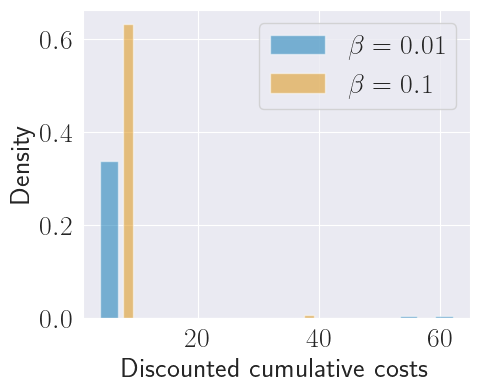

In [9]:
fig = plt.figure()
fig.set_size_inches(5.0, 4.0)
fig.tight_layout()

plt.hist(erm_bi_data[0.01]["f_vals"], density=True, bins=20, alpha=0.5, label=r'$\beta=0.01$')
plt.hist(erm_bi_data[0.1]["f_vals"], density=True, bins=20, alpha=0.5, label=r'$\beta=0.1$')
#plt.hist(erm_bi_data[1.0]["f_vals"], density=True, bins=20, alpha=0.5, label=r'$\beta=1.0$')
plt.ylabel('Density')
plt.xlabel("Discounted cumulative costs")
plt.grid()

plt.legend()
plt.show()

Accrued costs MCTS:

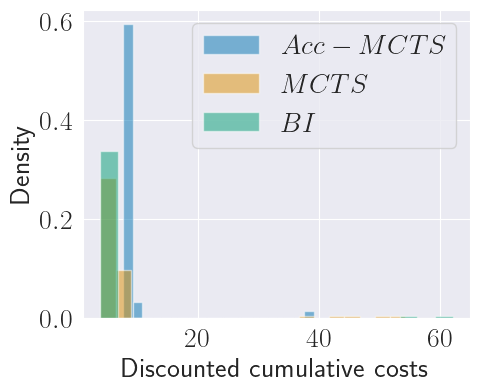

In [10]:
exp_steps_to_plot = 5_000
fig = plt.figure()
fig.set_size_inches(5.0, 4.0)
fig.tight_layout()

plt.hist(accrued_costs_mcts_planner_data[0.01][exp_steps_to_plot]["f_vals"], density=True, bins=20, alpha=0.5, label=r'$Acc-MCTS$')
plt.hist(erm_mcts_planner_data[0.01][exp_steps_to_plot]["f_vals"], density=True, bins=20, alpha=0.5, label=r'$MCTS$')
plt.hist(erm_bi_data[0.01]["f_vals"], density=True, bins=20, alpha=0.5, label=r'$BI$')
plt.ylabel('Density')
plt.xlabel("Discounted cumulative costs")
plt.grid()

plt.legend()
plt.show()

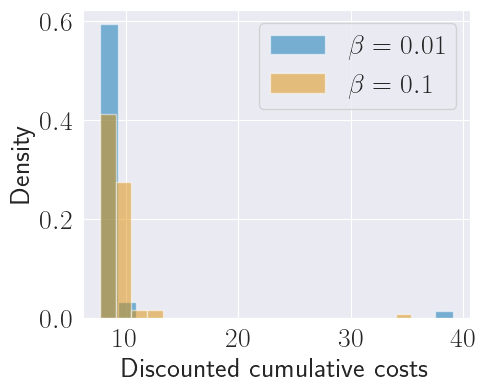

In [12]:
exp_steps_to_plot = 1000

fig = plt.figure()
fig.set_size_inches(5.0, 4.0)
fig.tight_layout()

plt.hist(accrued_costs_mcts_planner_data[0.01][exp_steps_to_plot]["f_vals"], density=True, bins=20, alpha=0.5, label=r'$\beta=0.01$')
plt.hist(accrued_costs_mcts_planner_data[0.1][exp_steps_to_plot]["f_vals"], density=True, bins=20, alpha=0.5, label=r'$\beta=0.1$')
#plt.hist(accrued_costs_mcts_planner_data[1.0][exp_steps_to_plot]["f_vals"], density=True, bins=20, alpha=0.5, label=r'$\beta=1.0$')
plt.ylabel('Density')
plt.xlabel("Discounted cumulative costs")
plt.grid()

plt.legend()
plt.show()

ERM-MCTS:

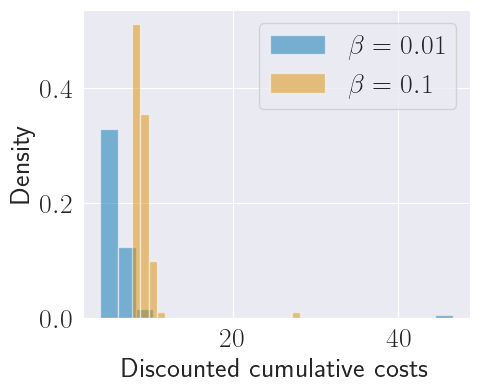

In [13]:
fig = plt.figure()
fig.set_size_inches(5.0, 4.0)
fig.tight_layout()

plt.hist(erm_mcts_planner_data[0.01][exp_steps_to_plot]["f_vals"], density=True, bins=20, alpha=0.5, label=r'$\beta=0.01$')
plt.hist(erm_mcts_planner_data[0.1][exp_steps_to_plot]["f_vals"], density=True, bins=20, alpha=0.5, label=r'$\beta=0.1$')
#plt.hist(erm_mcts_planner_data[1.0][exp_steps_to_plot]["f_vals"], density=True, bins=20, alpha=0.5, label=r'$\beta=1.0$')
plt.ylabel('Density')
plt.xlabel("Discounted cumulative costs")
plt.grid()

plt.legend()
# plt.show()

os.makedirs("figs/", exist_ok=True)
plt.savefig(f'figs/{mdp_name}_histo.pdf', bbox_inches='tight', pad_inches=0)

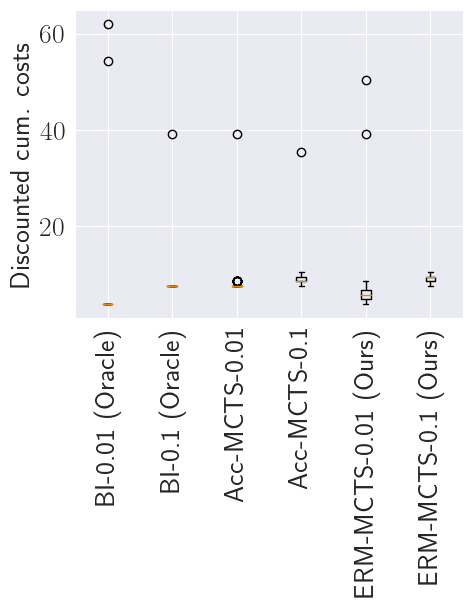

In [15]:
exp_steps_to_plot= 10_000

fig = plt.figure()
fig.set_size_inches(5.0, 4.0)
fig.tight_layout()

labels = []
data_to_plot = []
positions = [0,1]
for erm_beta, d in erm_bi_data.items():
    data_to_plot.append(d["f_vals"])
plt.boxplot(data_to_plot, positions=positions)
labels.extend(["BI-0.01 (Oracle)", "BI-0.1 (Oracle)"])

data_to_plot = []
positions = [2,3]
for erm_beta, d in accrued_costs_mcts_planner_data.items():
    data_to_plot.append(d[exp_steps_to_plot]["f_vals"])
plt.boxplot(data_to_plot, positions=positions)
labels.extend(["Acc-MCTS-0.01", "Acc-MCTS-0.1"])

data_to_plot = []
positions = [4,5]
for erm_beta, d in erm_mcts_planner_data.items():
    data_to_plot.append(d[exp_steps_to_plot]["f_vals"])
plt.boxplot(data_to_plot, positions=positions)
labels.extend(["ERM-MCTS-0.01 (Ours)", "ERM-MCTS-0.1 (Ours)"])

# plt.ylabel('Density')
plt.ylabel("Discounted cum. costs");
plt.grid()
plt.xticks(range(len(labels)), labels)

plt.xticks(rotation=90)

#plt.title(r'$f(d) = d^\top \log(d)$')
plt.savefig(f"figs/grid-mdp-distributions-comparison.pdf", bbox_inches='tight')
plt.show()